<a href="https://colab.research.google.com/github/Neelectric/TaD-Labs/blob/main/localLab_2_Geometric_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text as Data Lab 2: Geometric similarity

The goal of the first lab is discover several ways to represent documents as numerical vectors and how they can be used for calculating the similarity of our Reddit posts.

**Before you start, save a copy of this lab to your drive using "File > Save a Copy in Drive".** If you skip this step, you may lose progress that you have made (e.g., if you close the browser tab or your computer crashes).

This lab is linked with the second lecture. Please watch the lecture and refer to the slides as needed.

In this lab you will learn about:
- Representing documents with one-hot encoding, term frequency and TFIDF
- Storing vectors using dense and sparse representations
- Zipf's law
- Using the vectors to calculate similarity

**Note:** Colab may hide some of this lab by collapsing a section. You'd see something that says "X cells hidden" (like below). Click on it to expand that section of the lab.


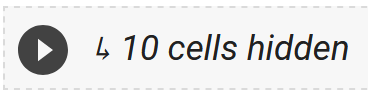

## Setting up the labtest function

As with the first lab, we'll use a `labtest` function so that you can check your code. You need to install and load it with the code below.

In [38]:
# Installs the labtest system and loads the tests for this specific lab

!pip install -U git+https://github.com/jakelever/glasgowcs_labtest.git
from glasgowcs_labtest.textasdata.lab2 import labtest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jakelever/glasgowcs_labtest.git to /tmp/pip-req-build-16qq7pck
  Running command git clone --filter=blob:none --quiet https://github.com/jakelever/glasgowcs_labtest.git /tmp/pip-req-build-16qq7pck
  Resolved https://github.com/jakelever/glasgowcs_labtest.git to commit e5a3451dd219109484ea26d43b08f83e6934d489
  Preparing metadata (setup.py) ... done


## Loading the Reddit data

We'll be using the same Reddit data from the previous labs. We will download it and tokenize it with [Spacy](https://spacy.io/) for later use.

First, let's download it:

In [39]:
!wget -O reddit_posts.json https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1

--2023-02-26 13:14:57--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9 [following]
--2023-02-26 13:14:57--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1279064 (1.2M) [application/json]
Saving to: ‘reddit_posts.json’

reddit_posts.json   100%[===================>]   1.22M  2.73MB/s    in 0.4s    

2023-02-26 13:14:58 (2.73 

Let's load in the posts:

In [40]:
import json
with open('reddit_posts.json') as f:
    posts = json.load(f)

len(posts)
type(posts)

list

And let's load Spacy.

In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")

And we'll use a function that we developed last lab to tokenize the posts.

In [42]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Example usage:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

And let's run it across all the posts to tokenize it. Recall that we can use the [tqdm library](https://tqdm.github.io/) to give us a nice progress bar.

In [43]:
from tqdm import tqdm # This provides a nice progress bar

for post in tqdm(posts):
    post['tokens'] = text_pipeline_spacy(post['title'] + '\n' + post['body'])

posts[0]

100%|██████████| 2000/2000 [00:45<00:00, 44.08it/s]


{'subreddit': 'Soda',
 'title': 'Anyone tried Irn Bru?',
 'score': 8,
 'id': 'ou5yp1',
 'author': 'jackibhoy',
 'body': 'It’s a Scottish drink and it’s banned some countries and I was wondering if anyone here has tried it. It has quite a unique taste and it’s not something you’d forget quickly. You either love it or hate it I think.',
 'tokens': ['try',
  'irn',
  'bru',
  'scottish',
  'drink',
  'ban',
  'country',
  'wonder',
  'try',
  'unique',
  'taste',
  'forget',
  'quickly',
  'love',
  'hate',
  'think']}

We'll use the full Reddit posts later on in the lab.

## Vector representation

In this lab, we're going to learn about another representation of documents. Last lab, we used [sets](https://docs.python.org/3/library/stdtypes.html#set) to represent the unique tokens of a document. This lab, we're going to use numerical vectors to represent documents.

Before we get started, here is a mini dataset that we'll use for a few of our functions. This is instead of running across the entire Reddit dataset for every function. We'll use the `text_pipeline_spacy` function from above to tokenize the sentences.

In [44]:
mini_sentences = [
    "My favourite soft drink is Apple Tango, but I also love Irn Bru.",
    "Irn Bru is a great drink.",
    "I once found a can of Irn Bru in St Petersburg.",
    "Irn Bru is a soft drink launched in 1901 by AG Barr.",
    "IRN-BRU is made at AG Barr in Cumbernauld."
]

mini_tokenized = [ text_pipeline_spacy(x) for x in mini_sentences ]

mini_tokenized

[['favourite', 'soft', 'drink', 'apple', 'tango', 'love', 'irn', 'bru'],
 ['irn', 'bru', 'great', 'drink'],
 ['find', 'irn', 'bru', 'st', 'petersburg'],
 ['irn', 'bru', 'soft', 'drink', 'launch', '1901', 'ag', 'barr'],
 ['irn', 'bru', 'ag', 'barr', 'cumbernauld']]



```
# This is formatted as code
```

### Building our own text vectorizer

There are a few components to a vectorizer including collecting the vocabulary of a set of documents and several different ways to turn a document into a vector, knowing that vocabulary. We're going to build this up from scratch so you understand all the parts.

#### The vocabulary

The first thing is to collect all the unique tokens in a corpus (collection of documents). And each unique token should be mapped to an integer ID, which should start from zero.

**Exercise:** Write a function `make_vocabulary` that takes a corpus (i.e. a list of lists of tokens like `mini_tokenized` above) and returns a dictionary with each unique token mapped to an integer, starting from zero. The order of the tokens does not matter.

For example, the output of `make_vocabulary( [ ['irn','bru','good'], ['irn','bru','bad'] ])` should be `{'bad': 0, 'bru': 1, 'good': 2, 'irn': 3}`. Recall that dictionaries can be created with `{}` just as lists are made with `[]`.

In [45]:
def make_vocabulary(corpus):
  # your code!
  vocab = {}
  index = 0
  for sublist in corpus:
    for elt in sublist:
      if elt in vocab:
        pass
      else:
        vocab[elt] = index
        index +=1

  return vocab

# Example usage:
make_vocabulary( [ ['irn','bru','good'], ['irn','bru','bad'] ])

{'irn': 0, 'bru': 1, 'good': 2, 'bad': 3}

Remember that you can test your code with the `labtest` function:

In [46]:
labtest(make_vocabulary)

----------------------------
LABTEST: Running 4 testcases
----------------------------
Input: [['irn', 'bru', 'good'], ['irn', 'bru', 'bad']]. Running... 
Input: [['go', 'fish', 'today'], ['went', 'fish', 'yesterday']]. Running... 
Input: [['glasgow', 'city', 'culture', '1990'], ['university', 'glasgow', 'founded', '1451']]. Running... 
Input: [['expanse', 'season', 'six', 'excellent']]. Running... 
----------------------------
4 testcases PASSED
----------------------------


Let's run it on our mini corpus to see what it happens.

In [47]:
make_vocabulary(mini_tokenized)

{'favourite': 0,
 'soft': 1,
 'drink': 2,
 'apple': 3,
 'tango': 4,
 'love': 5,
 'irn': 6,
 'bru': 7,
 'great': 8,
 'find': 9,
 'st': 10,
 'petersburg': 11,
 'launch': 12,
 '1901': 13,
 'ag': 14,
 'barr': 15,
 'cumbernauld': 16}

#### Dense vector representation

Now we have our vocabulary, we can start making vectors. We'll start off with a dense one-hot vector. For a vocabulary with `N` unique tokens, a dense vector will contain `N` elements. The one-hot vector means that it will be all zeros except for the elements corresponding to the tokens in that document which are one.

**Exercise:** Write a function `make_onehot_dense` that takes in the tokens of a document and the vocab dictionary and returns a one-hot vector (as a list) for that document.

In [48]:


def make_onehot_dense(tokens, vocab):
  # your code!
  output = []
  for option in vocab:
    if option in tokens:
      output.append(1)
    else:
      output.append(0)
  return output

# Example usage:
make_onehot_dense(['irn','bru','good','good'], {'irn':0,'bru':1,'good':2,'bad':3})
# irn bru good good
# [1,0,0,0]
# [0,1,0,0]
# [0,0,1,0]
# [0,0,1,0]

#(['text', 'university', 'good', 'good'], {'text': 0, 'python': 1, 'city': 2, 'good': 3, 'university': 4})
# [1,0,0,0,0]
# [0,0,0,0,1]
# [0,0,0,1,0]
# [0,0,0,1,0]

[1, 1, 1, 0]

In [49]:
labtest(make_onehot_dense)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['text', 'university', 'good', 'good'], {'text': 0, 'python': 1, 'city': 2, 'good': 3, 'university': 4}). Running... 
OK.
Input: (['coffee', 'university', 'culture', 'coffee'], {'coffee': 0, 'university': 1, 'culture': 2, 'city': 3}). Running... 
OK.
Input: (['university', 'good', 'city', 'university'], {'university': 0, 'city': 1, 'good': 2, 'python': 3}). Running... 
OK.
Input: (['university', 'shop', 'coffee', 'shop'], {'glasgow': 0, 'text': 1, 'coffee': 2, 'shop': 3, 'irn': 4, 'university': 5}). Running... 
OK.
Input: (['culture', 'city', 'culture', 'good', 'shop'], {'city': 0, 'good': 1, 'culture': 2, 'shop': 3}). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


You can run it on the mini corpus. You can use the mini corpus later on too if it's helpful to debug your code.

In [50]:
mini_vocab = make_vocabulary(mini_tokenized)
make_onehot_dense(mini_tokenized[0],mini_vocab)
print(mini_tokenized[0])

['favourite', 'soft', 'drink', 'apple', 'tango', 'love', 'irn', 'bru']


#### Sparse vector representation

Dense vectors have a big problem. They take up a lot of memory, even when containing only a few non-zero values. We can use a sparse representation that only stores the non-zero data.

Remember that a sparse representation is generally a good idea for sparse data (mostly zeros), and a dense representaiton (like above) is a good idea for dense data (mostly non-zeros). If you use the wrong one for the wrong data, you'll have a bad time.

We used a `list` to represent our dense vector as below.

In [51]:
dense_vector = [1,0,1,0,1]
type(dense_vector)

list

In the lecture, sparse data was shown as a list of pairs with the first number being the element index of the vector and the second element being the value in that element.

For practical reasons, we're going to use a `dict` to represent our sparse vector and not a list of pairs of numbers. This allows a quick look up of values in a sparse vector.

Below is a sparse vector that contains the same data as the `dense_vector` variable above.

In [52]:
sparse_vector = {0:1, 2:1, 4:1}
type(sparse_vector)

dict

Two useful things to know about dictionaries. 

1. You can give a second argument to the `get` function and if the dictionary doesn't contain it, it will return that value instead. For instance, the `sparse_vector` above doesn't contain a value at element 1:

In [53]:
sparse_vector.get(1,0)

0

2. Dictionaries have a function called `items()` that allows you to iterate over the keys and values in the dictionary:

In [54]:
# Introducing .items()
for index,val in sparse_vector.items():
  print(index, val)

0 1
2 1
4 1


**Exercise:** Write a function `sparse_to_dense` that converts a sparse vector (stored as a `dict`) to a dense vector (stored as a `list`). In this case, you also need to give the length of the vector: `vector_length`.

In [55]:
def sparse_to_dense(sv, vector_length):
  # your code!
  output = []
  for i in range(vector_length):
    output.append(sv.get(i,0))
  return output

# Example usage:
sparse_to_dense({0:1, 2:1, 4:1}, 5)

[1, 0, 1, 0, 1]

In [56]:
labtest(sparse_to_dense)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ({2: 1, 1: 4}, 4). Running... 
OK.
Input: ({4: 2}, 5). Running... 
OK.
Input: ({0: 1, 1: 2, 4: 4}, 7). Running... 
OK.
Input: ({1: 9, 3: 9}, 4). Running... 
OK.
Input: ({4: 8, 0: 5}, 5). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


Now that you can see the format of sparse vectors, we'll keep using them from now on. Dense vectors have some serious memory problems as we'll explore so it's good to stick with sparse vectors. Now it's time to rewrite the onehot vector function with sparse vectors.

**Exercise**: Write a function `make_onehot_sparse` that gives a one-hot vector like above but returns a sparse vector.

For performance reasons, you shouldn't create a dense vector and then convert it, or this lab will run very slowly.

In [57]:
#{0:1, 2:1, 4:1}
def make_onehot_sparse(tokens, vocab):
  # your code!
  output = {}
  for word in tokens:
    if vocab[word] not in output:
      output[vocab[word]] = 1
  return output


# Example usage:
#make_onehot_sparse(['irn','bru','good','good'], {'irn':0,'bru':1,'good':2,'bad':3})
make_onehot_sparse(['bad', 'irn', 'glasgow', 'glasgow', 'bad', 'bad'], {'bru': 0, 'irn': 1, 'glasgow': 2, 'bad': 3, 'coffee': 4, 'kelvin': 5})

{3: 1, 1: 1, 2: 1}

In [58]:
labtest(make_onehot_sparse)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['bad', 'irn', 'glasgow', 'glasgow', 'bad', 'bad'], {'bru': 0, 'irn': 1, 'glasgow': 2, 'bad': 3, 'coffee': 4, 'kelvin': 5}). Running... 
OK.
Input: (['kelvin', 'kelvin', 'irn', 'irn'], {'coffee': 0, 'shop': 1, 'irn': 2, 'kelvin': 3}). Running... 
OK.
Input: (['culture', 'good', 'city', 'culture'], {'irn': 0, 'good': 1, 'culture': 2, 'city': 3, 'glasgow': 4}). Running... 
OK.
Input: (['city', 'university', 'city', 'glasgow', 'shop', 'university'], {'city': 0, 'shop': 1, 'glasgow': 2, 'irn': 3, 'university': 4}). Running... 
OK.
Input: (['shop', 'shop', 'shop', 'bru', 'irn'], {'shop': 0, 'bad': 1, 'bru': 2, 'irn': 3, 'python': 4}). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


#### Memory usage of dense & sparse vectors

Let's explore the performance of dense versus sparse vectors with the Reddit data set. First, let's create a vocabulary. We need to pull out the tokens from each post to give to the `make_vocabulary` function.

In [59]:
post_tokens = [ p['tokens'] for p in posts ]
posts_vocab = make_vocabulary(post_tokens)

Next, we'll create dense and sparse vectors for every post

In [60]:
posts_dense = [ make_onehot_dense(p['tokens'], posts_vocab) for p in posts ]
posts_sparse = [ make_onehot_sparse(p['tokens'], posts_vocab) for p in posts ]

Now we want to check the memory requirements for each set of vectors. The `sys` module has a function `getsizeof`. However, it doesn't quite do what we want. As each set of vectors is a nested structure (e.g. a list of lists or a list of dicts), the `getsizeof` function doesn't calculate it properly as below.

In [61]:
import sys

# This doesn't work
print(f"sys.getsizeof(posts_dense)={sys.getsizeof(posts_dense)}")
print(f"sys.getsizeof(posts_sparse)={sys.getsizeof(posts_sparse)}")

sys.getsizeof(posts_dense)=16552
sys.getsizeof(posts_sparse)=16552


That's in bytes. They should take up more space than that!

Instead, we go to good-ol Stack Overflow as a nice person has written a recursive function that can go inside objects to calculate the size:

In [62]:
# From https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

def sizeof(obj):
  size = sys.getsizeof(obj)
  if isinstance(obj, dict): 
    return size + sum(map(sizeof, obj.keys())) + sum(map(sizeof, obj.values()))
  if isinstance(obj, (list, tuple, set, frozenset)):
    return size + sum(map(sizeof, obj))
  return size

The code below runs it for both datasets.

In [63]:
print(f"sizeof(posts_dense)={sizeof(posts_dense)}")
print(f"sizeof(posts_sparse)={sizeof(posts_sparse)}")

sizeof(posts_dense)=655020568
sizeof(posts_sparse)=6064964


Wow! The dense vectors do take up A LOT more memory than the sparse vectors. Let's delete the dense vectors (below) and Python will (eventually) clear the memory being used for them. We'll stick with the sparse vectors.

In [64]:
del posts_dense

#### Term frequency

The one-hot vector only captured whether a token was in a document or not. It doesn't show how frequently the token occurred. We discussed in class that the frequency (term frequency) may be important too as tokens that occur many times may give a clue about the document's topics.

Let's take a look at `Counter` first. It may be useful to you. It's a common Python data structure for counting things. You can create a Counter by giving it a list of things to count:

In [65]:
# Recall Counter
from collections import Counter
counts = Counter(['a','b','a','c'])
counts

Counter({'a': 2, 'b': 1, 'c': 1})

Or create an empty `Counter` and change the values of each element.

In [66]:
counts = Counter()
counts['a'] += 1
counts['b'] += 1
counts['a'] += 1
counts

Counter({'a': 2, 'b': 1})

**Exercise:** Write a function `make_tf_sparse` that creates a vector represention of a document with term-frequency values. Instead of ones and zeros as in `make_onehot_sparse`, the non-zero values should be the term frequencies. You may want to use `Counter`.

In [67]:
def make_tf_sparse(tokens, vocab):
  # your code!
  output = {}
  counts = Counter(tokens)
  for element in counts:
    output[vocab[element]] = counts[element]
  return output

# Example usage:
make_tf_sparse(['irn','bru','good','good'], {'irn':0,'bru':1,'good':2,'bad':3})

{0: 1, 1: 1, 2: 2}

In [68]:
labtest(make_tf_sparse)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['bad', 'irn', 'glasgow', 'glasgow', 'bad', 'bad'], {'bru': 0, 'irn': 1, 'glasgow': 2, 'bad': 3, 'coffee': 4, 'kelvin': 5}). Running... 
OK.
Input: (['kelvin', 'kelvin', 'irn', 'irn'], {'coffee': 0, 'shop': 1, 'irn': 2, 'kelvin': 3}). Running... 
OK.
Input: (['culture', 'good', 'city', 'culture'], {'irn': 0, 'good': 1, 'culture': 2, 'city': 3, 'glasgow': 4}). Running... 
OK.
Input: (['city', 'university', 'city', 'glasgow', 'shop', 'university'], {'city': 0, 'shop': 1, 'glasgow': 2, 'irn': 3, 'university': 4}). Running... 
OK.
Input: (['shop', 'shop', 'shop', 'bru', 'irn'], {'shop': 0, 'bad': 1, 'bru': 2, 'irn': 3, 'python': 4}). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


#### TF-IDF: Term frequency - inverse document frequency

The term frequency is certainly important, but maybe only important for some words. Some tokens are so common that they are expected to appear a lot. We've already filtered out many using the stopwords functionality of Spacy. But there will still be many unimportant words.

Now we're going to look at TF-IDF which normalizes term frequency with the number of documents that a term appears in. This means that terms that appear across a lot of documents are deemed less important. But first we need to know the number of documents that each token appears in.

**Exercise:** Write a function `doc_frequency` that takes a corpus (i.e. a list of token lists like `mini_tokenized` at the start) and returns a dictionary (or Counter) which maps each token to the number of documents it appears in.

For example, the input `[['a','b'], ['b','c']]` should give the output: `{'a':1, 'b':2, 'c':1}`

In [69]:
def doc_frequency(corpus):
  output = {}
  for text in corpus:
    counts = Counter(text)
    for elt in counts:
      if elt in output:
        output[elt] = output[elt] + 1
      else:
        output[elt] = 1
  return output

def doc_frequency_given_vocab(corpus,vocab):
  output = {}
  for elt in vocab.keys():
    output[elt] = 0
  for text in corpus:
    counts = Counter(text)
    for elt in counts:
      output[elt] = output[elt] + 1
  return output

# Example usage:
doc_frequency( [ ['a','a','b'], 
                 ['a','b','b','c'], 
                 ['a','d','e','f'] ] )

{'a': 3, 'b': 2, 'c': 1, 'd': 1, 'e': 1, 'f': 1}

In [70]:
labtest(doc_frequency)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ([['irn', 'kelvin'], ['glasgow', 'bad'], ['bru', 'glasgow'], ['glasgow', 'irn']],). Running... 
OK.
Input: ([['python', 'culture', 'bad'], ['bad', 'culture', 'culture', 'culture']],). Running... 
OK.
Input: ([['university', 'irn', 'university', 'culture'], ['bru', 'coffee']],). Running... 
OK.
Input: ([['bad', 'bru', 'glasgow', 'glasgow'], ['glasgow', 'bad'], ['bad', 'bru', 'kelvin']],). Running... 
OK.
Input: ([['city', 'bad', 'kelvin', 'coffee'], ['bru', 'city', 'kelvin', 'coffee']],). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


We can run it on the slightly larger set `mini_tokenized`.

In [71]:
doc_frequency(mini_tokenized)

{'favourite': 1,
 'soft': 2,
 'drink': 3,
 'apple': 1,
 'tango': 1,
 'love': 1,
 'irn': 5,
 'bru': 5,
 'great': 1,
 'find': 1,
 'st': 1,
 'petersburg': 1,
 'launch': 1,
 '1901': 1,
 'ag': 2,
 'barr': 2,
 'cumbernauld': 1}

Now we come to calculating TF-IDF. There are a few ways to calculate both the term frequency and inverse document frequency components.

As discussed in class, it can be a good idea to use logarithms during these calculations so that very frequent words aren't weighted too highly. 

Refer to the slides in Lecture 2 for the equations to use for term frequency and inverse document frequency respectively. We'll use log 10 for both equations. And recall that TF-IDF is TF multiplied by IDF for each token.

**Exercise:** Using the given definitions of TF and IDF, write a function  `make_tfidf_sparse` that returns the TF-IDF sparse vector for a document (given the list of tokens and the vocabulary mapping).

In [72]:
import math

def make_tfidf_sparse(tokens, vocab, doc_freq, N):
  sparse_vector = {}
  counts = Counter(tokens)
  for t,c in counts.items():
    tf = 1 + math.log10(c) if c > 0 else 0
    idf = math.log10(N / doc_freq[t])
    sparse_vector[vocab[t]] = tf*idf
      
  return sparse_vector
# Example usage:
make_tfidf_sparse(['irn','bru','good','good'],
                  {'irn':0,'bru':1,'good':2,'bad':3},
                  {'irn':4,'bru':4,'good':7,'bad':9},
                  10)

{0: 0.3979400086720376, 1: 0.3979400086720376, 2: 0.20153209632859362}

In [73]:
labtest(make_tfidf_sparse)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['irn', 'kelvin'], {'bru': 0, 'irn': 1, 'glasgow': 2, 'bad': 3, 'coffee': 4, 'kelvin': 5}, {'kelvin': 4, 'irn': 5, 'bad': 5, 'glasgow': 6, 'bru': 4, 'coffee': 3}, 10). Running... 
OK.
Input: (['bad', 'bru', 'glasgow', 'glasgow'], {'bru': 0, 'bad': 1, 'kelvin': 2, 'culture': 3, 'glasgow': 4}, {'bad': 3, 'glasgow': 4, 'bru': 5, 'kelvin': 5, 'culture': 3}, 8). Running... 
OK.
Input: (['kelvin', 'city', 'city'], {'kelvin': 0, 'shop': 1, 'culture': 2, 'python': 3, 'city': 4}, {'kelvin': 2, 'city': 4, 'culture': 2, 'python': 2, 'shop': 1}, 6). Running... 
OK.
Input: (['bru', 'good', 'glasgow'], {'coffee': 0, 'good': 1, 'kelvin': 2, 'bru': 3, 'glasgow': 4}, {'good': 5, 'glasgow': 6, 'bru': 5, 'kelvin': 5, 'coffee': 4}, 10). Running... 
OK.
Input: (['coffee', 'bru', 'bru', 'irn'], {'irn': 0, 'city': 1, 'bru': 2, 'coffee': 3}, {'irn': 2, 'coffee': 4, 'bru': 5, 'city': 3}, 6). Running... 
OK.
---------

#### Using your vectorizer with a new corpus

There are plenty of scenarios where you may want to vectorize new documents without starting from scratch and redefining your vocabulary:

- It may have been computationally expensive and you just want to add some more document vectors to your existing collection and don't care about any novel tokens
- You may be splitting your data into training and test sets for a machine learning experiment. You could want to vectorize your training set and test set separately but in the same way, using the vocabulary of your training set only.

Let's create some vectorizer functions that are happy to work with new text. The big hurdle is how to deal with tokens which aren't in your original vocabulary. There are two approaches:

1. Ignore them - very popular and actually makes a lot of sense. If you've never seen them before, you may not know what to do with them
2. Treat them as a special token `<UNK>` - may be useful for certain applications to know that there are new tokens in your text

Let's start with the first option. We'll do one-hot encoding as the functions will be simpler.

**Exercise:** Write a function `make_onehot_ignorenewtokens` which works like `make_onehot_sparse` and ignores any tokens that aren't in the vocabulary.

In [75]:
def make_onehot_ignorenewtokens(tokens, vocab):
  # your code!
  output = {}
  for word in tokens:
    if word in vocab.keys():
      output[vocab[word]] = 1
  return output

# Example usage:
make_onehot_ignorenewtokens(['irn','bru','fantastic'], {'irn':0,'bru':1,'good':2,'bad':3})

{0: 1, 1: 1}

In [76]:
# your code!
  vocab = {}
  index = 0
  for sublist in corpus:
    for elt in sublist:
      if elt in vocab:
        pass
      else:
        vocab[elt] = index
        index +=1

  return vocablabtest(make_onehot_ignorenewtokens)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['bad', 'irn', 'glasgow', 'edinburgh', 'glasgow', 'bad', 'bad'], {'bru': 0, 'irn': 1, 'glasgow': 2, 'bad': 3, 'coffee': 4, 'kelvin': 5}). Running... 
OK.
Input: (['thames', 'kelvin', 'kelvin', 'irn', 'clyde', 'irn'], {'coffee': 0, 'shop': 1, 'irn': 2, 'kelvin': 3}). Running... 
OK.
Input: (['culture', 'good', 'city', 'culture', 'books'], {'irn': 0, 'good': 1, 'culture': 2, 'city': 3, 'glasgow': 4}). Running... 
OK.
Input: (['city', 'university', 'edinburgh', 'city', 'glasgow', 'shop', 'university', 'library'], {'city': 0, 'shop': 1, 'glasgow': 2, 'irn': 3, 'university': 4}). Running... 
OK.
Input: (['shop', 'shop', 'shop', 'bru', 'irn', 'vimto'], {'shop': 0, 'bad': 1, 'bru': 2, 'irn': 3, 'python': 4}). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


# your code!
 
nd option for dealing with new tokens is to add a special `<UNK>` token (which stands for unknown) to the vocabulary and map everything new to that.

**Exercise:** Write a function `make_vocabulary_with_unk` (by slightly modifying `make_vocabulary`) that adds a `<UNK>` token to the vocabulary.

In [77]:
def make_vocabulary_with_unk(corpus):
  # your code!
  vocab = {}
  index = 0
  for sublist in corpus:
    for elt in sublist:
      if elt in vocab:
        pass
      else:
        vocab[elt] = index
        index +=1
  vocab["<UNK>"] = index
  return vocab



# Example usage:
make_vocabulary_with_unk( [ ['irn','bru','good'], ['irn','bru','bad'] ])

{'irn': 0, 'bru': 1, 'good': 2, 'bad': 3, '<UNK>': 4}

In [78]:
labtest(make_vocabulary_with_unk)

----------------------------
LABTEST: Running 4 testcases
----------------------------
Input: [['irn', 'bru', 'good'], ['irn', 'bru', 'bad']]. Running... 
Input: [['go', 'fish', 'today'], ['went', 'fish', 'yesterday']]. Running... 
Input: [['glasgow', 'city', 'culture', '1990'], ['university', 'glasgow', 'founded', '1451']]. Running... 
Input: [['expanse', 'season', 'six', 'excellent']]. Running... 
----------------------------
4 testcases PASSED
----------------------------


Now, time to use our vocabulary with `<UNK>` to create a vector.

**Exercise:** Write a `make_onehot_unk` function that create a sparse one hot encoding of the input tokens and maps any new tokens (not in the vocabulary) to the `<UNK>` token id.

In [79]:
def make_onehot_unk(tokens, vocab):
  # your code!
  output = {}
  for token in tokens:
    if token not in vocab:
      output["<UNK>"] = 1
    else:
      output[vocab[token]] = 1
  return output

# Example usage:
make_onehot_unk(['irn','bru','fantastic'], {'irn':0,'bru':1,'good':2,'bad':3,'<UNK>':4})

{0: 1, 1: 1, '<UNK>': 1}

### Zipf's Law

We'll take a little interlude to show why we used logarithms in the TFIDF equations. In basically any text corpus, there are a small number of very frequent tokens while most tokens appear fairly infrequently. This is known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf's_law). Let's see if it's true in our Reddit data.

First, let's get the counts for each token. This will look similar to your `doc_frequency` function above, but we're counting all mentions of tokens. So if it appears multiple times in a single document, every mention counts.

In [80]:
from collections import Counter
token_counts = Counter()
for post in posts:
  for token in post['tokens']:
    token_counts[token] += 1

We'll order them and calculate their rank (whether they are first, second, third, etc in the list). The `most_common` function on a Counter is nice as it returns the Counter data in descending order. We use a list comprehension with the [enumerate function](https://docs.python.org/3/library/functions.html#enumerate) to help us calculate the rank.

In [82]:
token_counts_in_order = token_counts.most_common(len(token_counts))
token_counts_with_rank = [ (i+1,t,c) for i,(t,c) in enumerate(token_counts_in_order)]

Let's have a look at the top ten tokens in the list. Remember that we have already removed stopwords (so things like "the" shouldn't appear).

In [83]:
token_counts_with_rank[:10]

[(1, 'game', 1327),
 (2, 'like', 942),
 (3, 'tea', 793),
 (4, 'know', 640),
 (5, 'play', 607),
 (6, 'try', 560),
 (7, 'good', 558),
 (8, 'water', 533),
 (9, 'want', 507),
 (10, 'get', 498)]

Now we're going to do some plotting. We'll use [plotly](https://plotly.com/python/) as it makes some nice interactive plots. To import it and make it place nice in Colab, we use the following code.

In [84]:
import plotly.io as pio
pio.renderers.default='colab'

Let's plot the token ranks against their frequency. You can move your mouse of points to see which token it is.

In [85]:
import plotly.express as px
fig = px.scatter(x=[ i for i,t,c in token_counts_with_rank ], 
                 y=[ c for i,t,c in token_counts_with_rank ], 
                 hover_name=[ t for i,t,c in token_counts_with_rank ], 
                 labels={
                     "x": "Rank",
                     "y": "Frequency"
                 })
fig.show()

You can see that there are a small number of tokens that have fairly high frequency while most have very small frequency. If we log-transform both the frequency and the rank, we get a smoother curve. This means that a small number of tokens no longer dominate.

In [86]:
import plotly.express as px
fig = px.scatter(x=[ i for i,t,c in token_counts_with_rank ], 
                 y=[ c for i,t,c in token_counts_with_rank ], 
                 hover_name=[ t for i,t,c in token_counts_with_rank ], 
                 labels={
                     "x": "Log Rank",
                     "y": "Log Frequency"
                 },
                log_x=True,
                log_y=True)
fig.show()

### Calculating similarity with sparse vectors

Back to our sparse vectors! We've calculated TF-IDF vectors but now we want to be able to compare them.

**Exercise:** Write a function that calculates the Euclidean distance between two sparse vectors. Think the hypotenuse of a right angled triangle, but in more dimensions. The `math.sqrt` function may be useful.

In [94]:
def sparse_euclidean_distance(sv1, sv2):
  # your code!
  #the square root of the sum of the squared differences between the two vectors.
  euclid_dis = 0
  s = set(sv1.keys()).union(sv2.keys())
  for elt in s:
    diff = sv1.get(elt, 0) - sv2.get(elt, 0)
    sqr_diff = diff ** 2
    euclid_dis += sqr_diff

  return math.sqrt(euclid_dis)
    
sv1 = {0:2, 2:1, 4:1}
sv2 = {0:1, 1:1, 2:3}
    
# Example usage:
sparse_euclidean_distance(sv1,sv2)

2.6457513110645907

In [95]:
labtest(sparse_euclidean_distance)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ({2: 1}, {0: 3}). Running... 
OK.
Input: ({1: 2, 0: 1}, {0: 4, 2: 1}). Running... 
OK.
Input: ({0: 2, 4: 2}, {4: 5, 0: 2}). Running... 
OK.
Input: ({5: 2, 4: 4, 3: 5}, {2: 4, 0: 3, 1: 3}). Running... 
OK.
Input: ({1: 1, 6: 1, 2: 4}, {0: 5, 2: 3, 5: 1}). Running... 
OK.
----------------------------
5 testcases PASSED
----------------------------


The Euclidean distance is actually rather computationally expensive. A more common method is the angle between two vectors. We use the cosine rule to calculate it which uses the dot product. One way to optimise this approach is to normalize all your vectors so that they have length 1.

**Exercise:** Write a function `normalize_sparse_vector` that takes a sparse vector and returns a normalized version of it. This is a vector pointing in the same direction but with unit length (=1)

In [ ]:
def normalize_sparse_vector(sv):
  # your code!

# Example usage:
normalize_sparse_vector({1:1,2:2})

In [ ]:
labtest(normalize_sparse_vector)

Recall that two vectors pointing in the same direction will have an angle of zero between them and a cosine of one. Whereas two angles that are orthogonal will have an angle of ninety degrees and a cosine of zero.

To calculate the cosine of an angle between two normalized vectors, you calculate a dot product. 

**Exercise:** Write a function `sparse_dot_prod` that calculates the dot product between two vectors. It can assume that the vectors it is given are already normalized.

In [ ]:
def sparse_dot_prod(sv1, sv2):
  # your code!

sv1 = normalize_sparse_vector({0:2, 2:1, 4:1})
sv2 = normalize_sparse_vector({0:1, 1:1, 2:3})
    
# Example usage:
sparse_dot_prod(sv1,sv2)

In [ ]:
labtest(sparse_dot_prod)

Lastly, let's combine these two ideas together to create a single function that calculates the cosine similarity. Recall that the equation for the cosine similarity is:

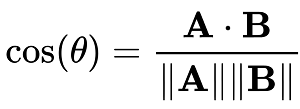

**Exercise:** Write a `cosine_similarity` function that takes two sparse vectors and calculates the cosine similarity. The input vectors may not be normalized. An inefficient way would be to use the normalize function above first before doing a dot product. Try to calculate the cosine similarity without using `normalize_sparse_vector` by calculating the magnitudes of the two vectors and use the equation above.

In [ ]:
def sparse_cosine_similarity(sv1, sv2):
  # your code!

# Example usage:
sparse_cosine_similarity({0:1,1:2},{0:2,1:3})

In [ ]:
labtest(sparse_cosine_similarity)

### Performance on our Reddit data

First, let's calculate the TFIDF vectors for our Reddit posts using our previous `make_tfidf_sparse` function,

In [ ]:
posts_tokens = [ p['tokens'] for p in posts ]
posts_vocab = make_vocabulary(posts_tokens)
posts_docfreq = doc_frequency(posts_tokens)
N = len(posts)

posts_tfidf_vectors = [ make_tfidf_sparse(pt, posts_vocab, posts_docfreq, N) for pt in posts_tokens ]

To use our dot product function, we first need to create a normalized version of the vectors.

In [ ]:
posts_norm_vectors = [ normalize_sparse_vector(sv) for sv in posts_tfidf_vectors ]

Now let's do a little performance calculation. We can use the `%timeit` macro to get our notebook to calculate the time for getting the euclidean distance between one vector and the rest of them.

In [ ]:
%timeit [ sparse_euclidean_distance(posts_tfidf_vectors[0],sv) for sv in posts_tfidf_vectors ]

How does that compare to calculating the cosine similarity?

In [ ]:
%timeit [ sparse_cosine_similarity(posts_tfidf_vectors[0],sv) for sv in posts_tfidf_vectors ]

And lastly, how does it compare to calculating the cosine similarity by doing the dot products of normalized vectors?

In [ ]:
%timeit [ sparse_dot_prod(posts_norm_vectors[0],sv) for sv in posts_norm_vectors ]

The dot product function should be the fastest of the three. Admittedly, some preprocessing (the normalization) was needed, but if you are calculating a lot of similarities, it's clearly the best option. And that's without all the performance enhancements that modern CPUs have specifically for doing vector calculations which are perfect for dot products.

### Calculating similarity on our Reddit data

We'll go back to our Reddit posts. Let's remind ourselves how many posts there are.

In [ ]:
len(posts)

And we have a matching number of normalized sparse vectors:

In [ ]:
len(posts_norm_vectors)

We can use the same code from last lab to iterate through our posts, calculate a similarity score and save it. Recall that the dot product of normalized vectors is giving us the cosine between the TFIDF vectors for the Reddit posts.

In [ ]:
scores_with_posts = []
target_vector = posts_norm_vectors[0]
for sv,post in zip(posts_norm_vectors,posts):
  similarity_score = sparse_dot_prod(target_vector,sv)
  scores_with_posts.append( (similarity_score, post))

Next we sort them. We again use `reverse=True` to get the highest scores first, and use the `key` function to only sort by the similarity score (and not try to sort the posts themselves which will fail).

In [ ]:
sorted_scores_with_posts = sorted(scores_with_posts, reverse=True, key=lambda x:x[0])

And output the top ten:

In [ ]:
for score,post in sorted_scores_with_posts[:10]:
    print(f"{score:.2f}\t{post['title']}")

Fantastic! We see various similar posts. There seem to be more about Irn Bru this time and about sodas

### Using scikit-learn for vectorizing text

Well done! You wrote a vectorizer from scratch. We're now going to look at scikit-learn's vectorizer functionality.

Scikit-learn provides some excellent documentation. On most pages, there's a short bit of example code. This exercise is going to illustrate using scikit-learn's documentation.

**Exercise**: Using the documentation of the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class, write a function `tfidf_vectorize_with_sklearn` that uses a vectorizer to fit and transform a text corpus and returns the result which is a sparse matrix. Look at the example code on the documentation page, about halfway down the page. Yes, this is basically a copy and paste exercise 😀. Remember to `import` the TfidfVectorizer and use the defaults for TfidfVectorizer - i.e. don't change anything.

In [ ]:
def tfidf_vectorize_with_sklearn(text_corpus):
  # your code!

# Example usage:
tfidf_vectorize_with_sklearn(
  [
    "My favourite soft drink is Apple Tango, but I also love Irn Bru.",
    "Irn Bru is a great drink.",
  ]
)

In [ ]:
labtest(tfidf_vectorize_with_sklearn)

Let's look at what the TfidfVectorizer is giving us:

In [ ]:
sparse_matrix = tfidf_vectorize_with_sklearn(
  [
    "My favourite soft drink is Apple Tango, but I also love Irn Bru.",
    "Irn Bru is a great drink.",
  ]
)

type(sparse_matrix)

It's a `csr_matrix` from the [scipy](https://scipy.org/) library which provides various data structures. This is one of them. It's a sparse matrix, similar in concept to our sparse vectors. It only store the locations and data of non-zero values.

Below is some code showing how you can create one of these:

In [ ]:
from scipy.sparse import csr_matrix

vector = [0,2,0,3,0,1]
sparse_matrix = csr_matrix(vector)
sparse_matrix

Notice that the description says "3 stored elements". It hasn't stored the zero elements.

Another useful thing is to know the size of a matrix:

In [ ]:
sparse_matrix.shape

You can get a dense version of your matrix using the `todense` function:

In [ ]:
sparse_matrix.todense()

**Exercise:** With a very small change to the previous function, write a function `tfidf_vectorize_with_sklearn_and_spacy` that combines the `TfidfVectorizer` with our previously written `text_pipeline_spacy`. The tokenizer argument (as descibed on [documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) may come in hand.

In [ ]:
def tfidf_vectorize_with_sklearn_and_spacy(text_corpus):
  # your code!

# Example usage:
tfidf_vectorize_with_sklearn_and_spacy(
    [
        "My favourite soft drink is Apple Tango, but I also love Irn Bru.",
        "Irn Bru is a great drink.",
    ]
)

In [ ]:
labtest(tfidf_vectorize_with_sklearn_and_spacy)

At the moment, we're creating a vectorizer and then throwing it away. You may want to keep it if you want to vectorize future documents, or look up which element of the vector corresponds to which token (e.g. what our `make_vocabulary` function gives us). You can get the list of tokens used for mapping from the vectorizer's `get_feature_names_out` function.

In [ ]:
text_corpus = ['Glasgow smiles better', 'He smiles a lot']

vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)
X = vectorizer.fit_transform(text_corpus)
vectorizer.get_feature_names_out()

Now let's run the TfidfVectorizer on the Reddit data. It may take a minute (and there's no way to get a nice progress bar 😞)

In [ ]:
texts_of_posts = [ p['title'] + '\n' + p['body'] for p in posts ]
post_tfidf_matrix = tfidf_vectorize_with_sklearn_and_spacy(texts_of_posts)
post_tfidf_matrix

We've now got our sparse matrix for the 2000 posts. We can double check that the sizes match:

In [ ]:
print(f"len(posts)={len(posts)}")
print(f"post_tfidf_matrix.shape={post_tfidf_matrix.shape}")

assert len(posts) == post_tfidf_matrix.shape[0]

`TfidfVectorizer` very nicely provides normalized vectors as output by default. This means we can calculate the dot product using these vectors to get the cosine similarities. Scipy provides a `dot` function that does a dot product with another vector.

To dot product a (1,9828) vector with another vector of the same size, you need to transpose the second vector. For this, you can use `.T` as below.

The code below calculates the dot product for our target vector against all the others.

In [ ]:
scores_with_posts = []
target_vector = post_tfidf_matrix[0,:]
for i,post in enumerate(posts):
  dotprod = target_vector.dot(post_tfidf_matrix[i,:].T)
  similarity_score = dotprod[0,0]
  scores_with_posts.append( (similarity_score, post))

We sort and output the top ten. Looks pretty similar, but oddly not exactly the same as our code. This is because scikit-learn uses slightly different definitions of TF and IDF for the TF-IDF calculation. Some of the parameters to TfidfVectorizer can adjust which equations to use.

In [ ]:
sorted_scores_with_posts = sorted(scores_with_posts, reverse=True, key=lambda x:x[0])

for score,post in sorted_scores_with_posts[:10]:
    print(f"{score:.2f}\t{post['title']}")

One big benefit of using scikit-learn and scipy's sparse matrices (apart from shorter code) is performance. We can calculate an all-by-all comparison by matrix multiplying the sparse matrix of normalized TFIDF vectors by itself transposed (which uses the `dot` function again).

In [ ]:
all_pairs_comparison = post_tfidf_matrix.dot(post_tfidf_matrix.T)
all_pairs_comparison = all_pairs_comparison.todense() # It's dense data now, so let's store it as dense

all_pairs_comparison.shape

This gives us a 2000x2000 matrices where element `(i,j)` is the cosine similarity between post `i` and post `j`. You could then slice out row `i` to see the similarity scores of all documents against post `i`.

## Optional Extras

These are optional directions to go into more detail.

1. Scikit-learn provides a HashingVectorizer as an alternative to a TfidfVectorizer. Can you find out why?
2. Vector similarity scores can be used for all sorts of applications, including clustering. You'll build K-Means from scratch in your assessed coursework, but Scikit-learn provides many built-in clustering implementations. This includes [hierachical clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) we discussed in lecture. Can you find any interesting clusters using this technique?
